In [1]:
import tensorflow as tf
import os


DATA_DIR = '../dataset/cat_and_dog_dataset'

IMAGE_DIR = os.path.join(DATA_DIR, 'JPEGImages')
MASK_DIR = os.path.join(DATA_DIR, 'encoded_masks')

In [2]:
image_filenames = sorted(os.listdir(IMAGE_DIR))
image_paths = [os.path.join(IMAGE_DIR, fname) for fname in image_filenames]
mask_paths = [os.path.join(MASK_DIR, fname) for fname in image_filenames]


# Create the initial dataset of file path pairs
full_dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))


2025-08-31 00:50:57.027407: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-08-31 00:50:57.027458: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-08-31 00:50:57.027463: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-08-31 00:50:57.027780: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-08-31 00:50:57.027799: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
DATASET_SIZE = len(image_paths)
TRAIN_SIZE = int(0.8 * DATASET_SIZE) # 80% for training
VAL_SIZE = DATASET_SIZE - TRAIN_SIZE # 20% for validation


full_dataset = full_dataset.shuffle(buffer_size=DATASET_SIZE)

train_dataset = full_dataset.take(TRAIN_SIZE)
val_dataset = full_dataset.skip(TRAIN_SIZE)

print(f"Total examples: {DATASET_SIZE}")
print(f"Training examples: {len(train_dataset)}")
print(f"Validation examples: {len(val_dataset)}")

Total examples: 305
Training examples: 244
Validation examples: 61


In [5]:
IMG_HEIGHT = 128
IMG_WIDTH = 128

In [6]:
def load_and_preprocess(img_path, label_path):
    # 1. Read and decode the image
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    # Normalize pixel values to be between 0 and 1
    img = tf.cast(img, tf.float32) / 255.0

    # 2. Read and decode the label (mask)
    label = tf.io.read_file(label_path)
    label = tf.image.decode_png(label, channels=1)
    # Use 'nearest' neighbor resizing for masks to avoid creating new class values
    label = tf.image.resize(label, [IMG_HEIGHT, IMG_WIDTH], method='nearest')

    return img, label

In [7]:
BATCH_SIZE = 32
BUFFER_SIZE = 200 

In [8]:
train_batches = (
    train_dataset
    .map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()  # Cache data for faster subsequent epochs
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat() # Repeat the dataset indefinitely
    .prefetch(buffer_size=tf.data.AUTOTUNE) # Prepares the next batches while the current one is processed
)

In [9]:
val_batches = (
    val_dataset
    .map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [10]:
import os
import tensorflow as tf

DATA_DIR = '../dataset/cat_and_dog_dataset'
IMAGE_DIR = os.path.join(DATA_DIR, 'JPEGImages')
MASK_DIR = os.path.join(DATA_DIR, 'encoded_masks')

# Get all image and mask files
image_files = sorted([f for f in os.listdir(IMAGE_DIR) if f.endswith('.jpg')])
mask_files = sorted([f for f in os.listdir(MASK_DIR) if f.endswith('.png')])

# Create a mapping from base name to mask path
mask_map = {os.path.splitext(f)[0]: os.path.join(MASK_DIR, f) for f in mask_files}

# Filter image paths to include only those with masks
image_paths = []
mask_paths = []

for img in image_files:
    base = os.path.splitext(img)[0]  # remove extension
    if base in mask_map:
        image_paths.append(os.path.join(IMAGE_DIR, img))
        mask_paths.append(mask_map[base])

print(f"Total pairs: {len(image_paths)}")
print(f"Example pair:\nImage: {image_paths[0]}\nMask: {mask_paths[0]}")

Total pairs: 305
Example pair:
Image: ../dataset/cat_and_dog_dataset/JPEGImages/cat.301.jpg
Mask: ../dataset/cat_and_dog_dataset/encoded_masks/cat.301.png


In [11]:
import tensorflow as tf

full_dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))

In [12]:
import os
import tensorflow as tf

DATA_DIR = '../dataset/cat_and_dog_dataset'
IMAGE_DIR = os.path.join(DATA_DIR, 'JPEGImages')
MASK_DIR = os.path.join(DATA_DIR, 'encoded_masks')

# ✅ Correct pairing
image_files = sorted([f for f in os.listdir(IMAGE_DIR) if f.endswith('.jpg')])
mask_files = sorted([f for f in os.listdir(MASK_DIR) if f.endswith('.png')])

mask_map = {os.path.splitext(f)[0]: os.path.join(MASK_DIR, f) for f in mask_files}

image_paths = []
mask_paths = []

for img in image_files:
    base = os.path.splitext(img)[0]
    if base in mask_map:
        image_paths.append(os.path.join(IMAGE_DIR, img))
        mask_paths.append(mask_map[base])

print(f"Total pairs: {len(image_paths)}")
print("Example:", image_paths[0], "->", mask_paths[0])

# ✅ Build dataset
full_dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))

DATASET_SIZE = len(image_paths)
TRAIN_SIZE = int(0.8 * DATASET_SIZE)
VAL_SIZE = DATASET_SIZE - TRAIN_SIZE

full_dataset = full_dataset.shuffle(buffer_size=DATASET_SIZE)
train_dataset = full_dataset.take(TRAIN_SIZE)
val_dataset = full_dataset.skip(TRAIN_SIZE)

IMG_HEIGHT = 128
IMG_WIDTH = 128

def load_and_preprocess(img_path, label_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img = tf.cast(img, tf.float32) / 255.0

    label = tf.io.read_file(label_path)
    label = tf.image.decode_png(label, channels=1)
    label = tf.image.resize(label, [IMG_HEIGHT, IMG_WIDTH], method='nearest')

    return img, label

BATCH_SIZE = 32
BUFFER_SIZE = 200

train_batches = (
    train_dataset
    .map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .prefetch(tf.data.AUTOTUNE)
)

val_batches = (
    val_dataset
    .map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

Total pairs: 305
Example: ../dataset/cat_and_dog_dataset/JPEGImages/cat.301.jpg -> ../dataset/cat_and_dog_dataset/encoded_masks/cat.301.png



--- Verifying a batch ---
Images batch shape: (32, 128, 128, 3)
Labels batch shape: (32, 128, 128, 1)


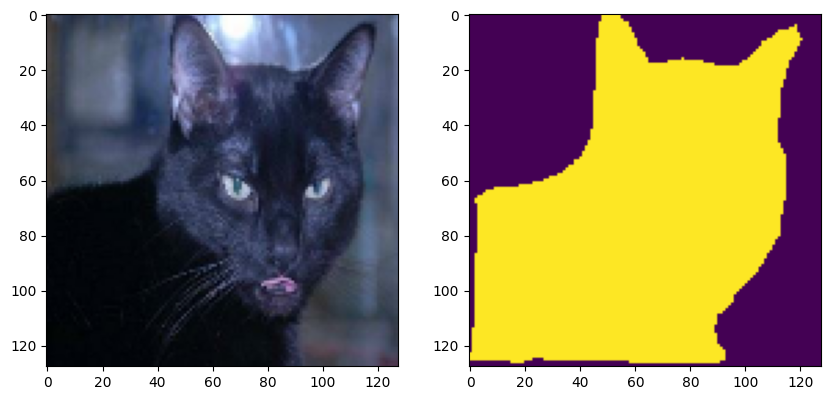

In [13]:
import matplotlib.pyplot as plt
temp_label =None
for images, labels in train_batches.take(1):
    print("\n--- Verifying a batch ---")
    print("Images batch shape:", images.shape)
    print("Labels batch shape:", labels.shape)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    indx = 0
    
    temp_label = labels[indx]
    axes[0].imshow(images[indx])
    axes[1].imshow(labels[indx],cmap='viridis')
    break
plt.show()

    

In [14]:
import numpy as np
color_value_list = set()
label_numpy = temp_label.numpy()
unique_values = np.unique(label_numpy)
print(unique_values)


for row in range(IMG_WIDTH):
    for col in range(IMG_HEIGHT):
        color_value = label_numpy[row, col][0]
        color_value_list.add(color_value)
        
print(color_value_list) 

[0 1]
{0, 1}


## Build the U-Net Model


In [37]:
import tensorflow as tf
from tensorflow.keras import layers


def build_unet_with_mobilenet(input_shape, num_classes):
    """
    U-Net with MobileNetV2 encoder, properly upsamples to match (H, W).
    """

    base_model = tf.keras.applications.MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )

    # Skip connection layers
    layer_names = [
        'block_1_expand_relu',   # 64x64
        'block_3_expand_relu',   # 32x32
        'block_6_expand_relu',   # 16x16
        'block_13_expand_relu',  # 8x8
        'out_relu',              # 4x4 (bottleneck)
    ]
    base_outputs = [base_model.get_layer(name).output for name in layer_names]
    encoder = tf.keras.Model(inputs=base_model.input, outputs=base_outputs, name="encoder")
    encoder.trainable = False

    # Input
    inputs = tf.keras.Input(shape=input_shape)
    skips = encoder(inputs)
    x = skips[-1]  # Start from bottleneck
    skips = skips[:-1][::-1]  # Reverse skip list (largest to smallest)

    # Decoder
    decoder_filters = [512, 256, 128, 64]  # One per skip
    for i, (skip, f) in enumerate(zip(skips, decoder_filters)):
        x = layers.Conv2DTranspose(f, 3, strides=2, padding='same')(x)
        x = layers.Concatenate()([x, skip])
        x = layers.Conv2D(f, 3, activation='relu', padding='same')(x)
        x = layers.Conv2D(f, 3, activation='relu', padding='same')(x)

    # Final upsampling to match 128x128
    outputs = layers.Conv2DTranspose(
        num_classes, 3, strides=2, padding='same', activation='softmax'
    )(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="U-Net-MobileNet")
    return model

In [38]:
NUM_CLASSES = 3
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
model = build_unet_with_mobilenet(input_shape, NUM_CLASSES)
model.summary()

Model: "U-Net-MobileNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder             │ [(None, 64, 64,   │  2,257,984 │ input_layer_5[0]… │
│ (Functional)        │ 96), (None, 32,   │            │                   │
│                     │ 32, 144), (None,  │            │                   │
│                     │ 16, 16, 192),     │            │                   │
│                     │ (None, 8, 8,      │            │                   │
│                     │ 576), (None, 4,   │            │                   │
│                     │ 4, 1280)]         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_6  │ (None, 8, 8, 512) │  5,898,752 │ encoder[0][4]     │
│ (Conv2DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 8, 8,      │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 1088)             │            │ encoder[0][3]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8, 512) │  5,014,016 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 8, 8, 512) │  2,359,808 │ conv2d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_7  │ (None, 16, 16,    │  1,179,904 │ conv2d_10[0][0]   │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 16, 16,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 448)              │            │ encoder[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 16, 16,    │  1,032,448 │ concatenate_5[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 16, 16,    │    590,080 │ conv2d_11[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_8  │ (None, 32, 32,    │    295,040 │ conv2d_12[0][0]   │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 32, 32,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 272)              │            │ encoder[0][1]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 32, 32,    │    313,472 │ concatenate_6[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 32, 32,    │    147,584 │ conv2d_13[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_9  │ (None, 64, 64,    │     73,792 │ conv2d_14[0][0]   │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 64, 64,    │          0 │ conv2d_transpose

 Total params: 19,293,763 (73.60 MB)

 Trainable params: 17,035,779 (64.99 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [39]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [48]:
EPOCHS = 30
STEPS_PER_EPOCH = len(train_dataset) // BATCH_SIZE
print(STEPS_PER_EPOCH)

7


In [49]:
import sys, shutil
print(sys.executable)          # must point to the pipenv Python
import pydot
print("pydot OK")
print("dot path:", shutil.which("dot"))  # must not be None

/Users/khinchaw/.local/share/virtualenvs/KhinChaw-88KTmf34/bin/python
pydot OK
dot path: /opt/homebrew/bin/dot


In [50]:
import pydot
import graphviz
import shutil

print("pydot OK")
print("graphviz OK")
print("dot path:", shutil.which("dot"))

pydot OK
graphviz OK
dot path: /opt/homebrew/bin/dot


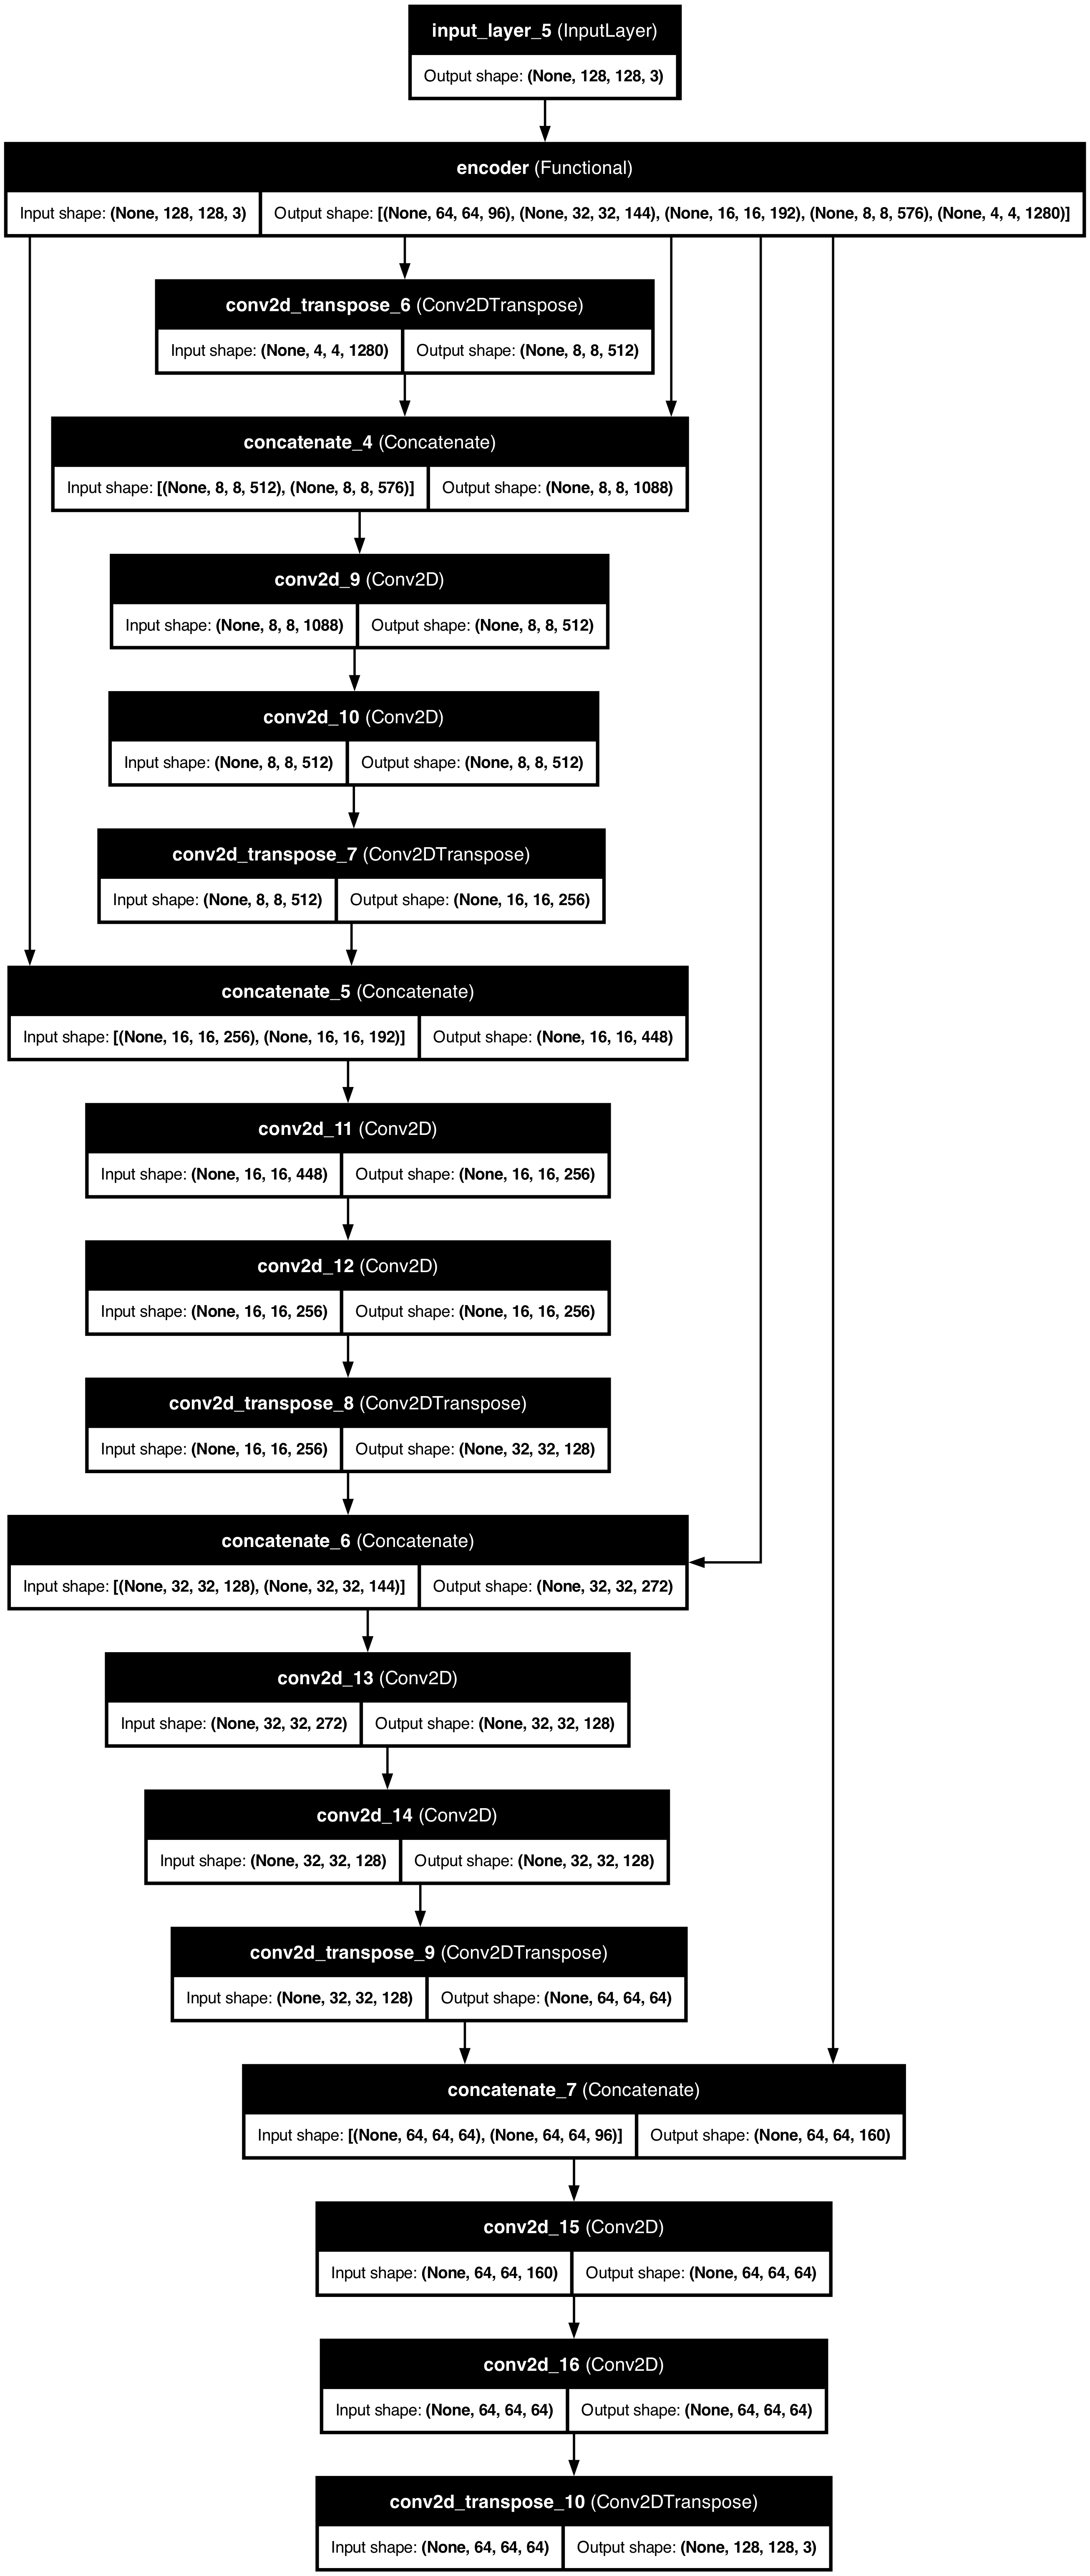

In [51]:
from tensorflow.keras.utils import plot_model

# pip install pydot
# Save model architecture as image
plot_model(model, to_file="tf_lr_model_architecture.png", show_shapes=True, show_layer_names=True)

In [52]:

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=3, 
    min_lr=1e-6
)

history = model.fit(
    train_batches,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=val_batches,
    callbacks=[lr_scheduler]
)

Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 830ms/step - accuracy: 0.8998 - loss: 0.2545 - val_accuracy: 0.9092 - val_loss: 0.2325 - learning_rate: 2.0000e-04
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 833ms/step - accuracy: 0.9075 - loss: 0.2320 - val_accuracy: 0.9126 - val_loss: 0.2252 - learning_rate: 2.0000e-04
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 789ms/step - accuracy: 0.9067 - loss: 0.2298 - val_accuracy: 0.9149 - val_loss: 0.2072 - learning_rate: 2.0000e-04
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 912ms/step - accuracy: 0.9156 - loss: 0.2067 - val_accuracy: 0.9164 - val_loss: 0.2063 - learning_rate: 2.0000e-04
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 832ms/step - accuracy: 0.9123 - loss: 0.2164 - val_accuracy: 0.9224 - val_loss: 0.1878 - learning_rate: 2.0000e-04
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 776ms/step - accuracy: 0.9172 - loss: 0.1998 - val_accuracy: 0.9179 - val_loss: 0.1942 - learning_rate: 2.0000e-04
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.9245 - loss: 0.

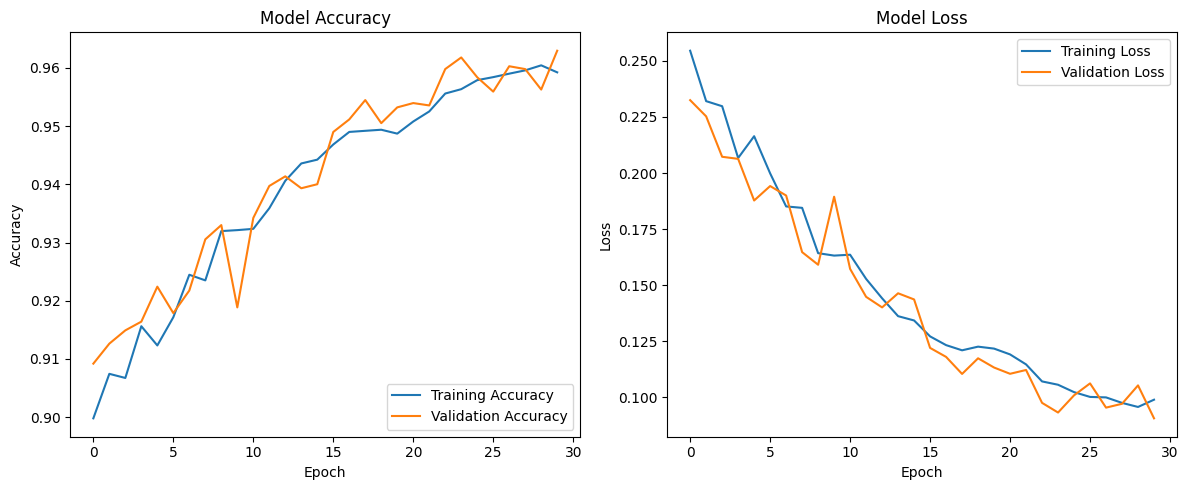

In [53]:
import matplotlib.pyplot as plt


has_validation_data = 'val_loss' in history.history


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
if has_validation_data:
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
if has_validation_data:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [54]:
print("Evaluating model on the test set...")
loss, accuracy = model.evaluate(val_batches)

print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Evaluating model on the test set...
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 392ms/step - accuracy: 0.9620 - loss: 0.0924

Test Loss: 0.0924
Test Accuracy: 0.9620


### Model Saving and Prediction

In [55]:
import os

os.makedirs('models', exist_ok=True)  # Create 'models' folder if it doesn't exist
model.save('models/cat_and_dog_unet.keras')

In [56]:
model.save('models/cat_and_dog_unet.keras')

In [57]:
loaded_model = tf.keras.models.load_model('models/cat_and_dog_unet.keras')

In [58]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [59]:
def model_predict(image_path, model):
    # This must be IDENTICAL to your training preprocessing
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img_normalized = tf.cast(img, tf.float32) / 255.0
    

    img_batch = tf.expand_dims(img_normalized, axis=0)

    # Predict
    predicted_masks = model.predict(img_batch)
    return predicted_masks , img
    

In [60]:
def predict_and_visualize(image_path, model):

   
    predicted_masks,img = model_predict(image_path, model)

    # The output is (1, H, W, num_classes).
    #  We take the argmax along the
    # class axis to get the final mask (1, H, W).
    pred_mask = tf.argmax(predicted_masks, axis=-1)
    
    # Remove the batch dimension to get a displayable image (H, W)
    pred_mask = pred_mask[0]
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.title("Input Image")
    # Display the original, un-normalized image
    plt.imshow(tf.keras.utils.array_to_img(img))
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title("Predicted Mask")
    plt.imshow(pred_mask)
    plt.axis('off')
    
    plt.show()

In [64]:
import os
print(os.getcwd())

/Users/khinchaw/Documents/GitHub/Practical-ML-by-WAI/8_final_project/KhinChaw/notebooks


In [65]:
import os
os.environ["PATH"] += os.pathsep + "/opt/homebrew/bin"

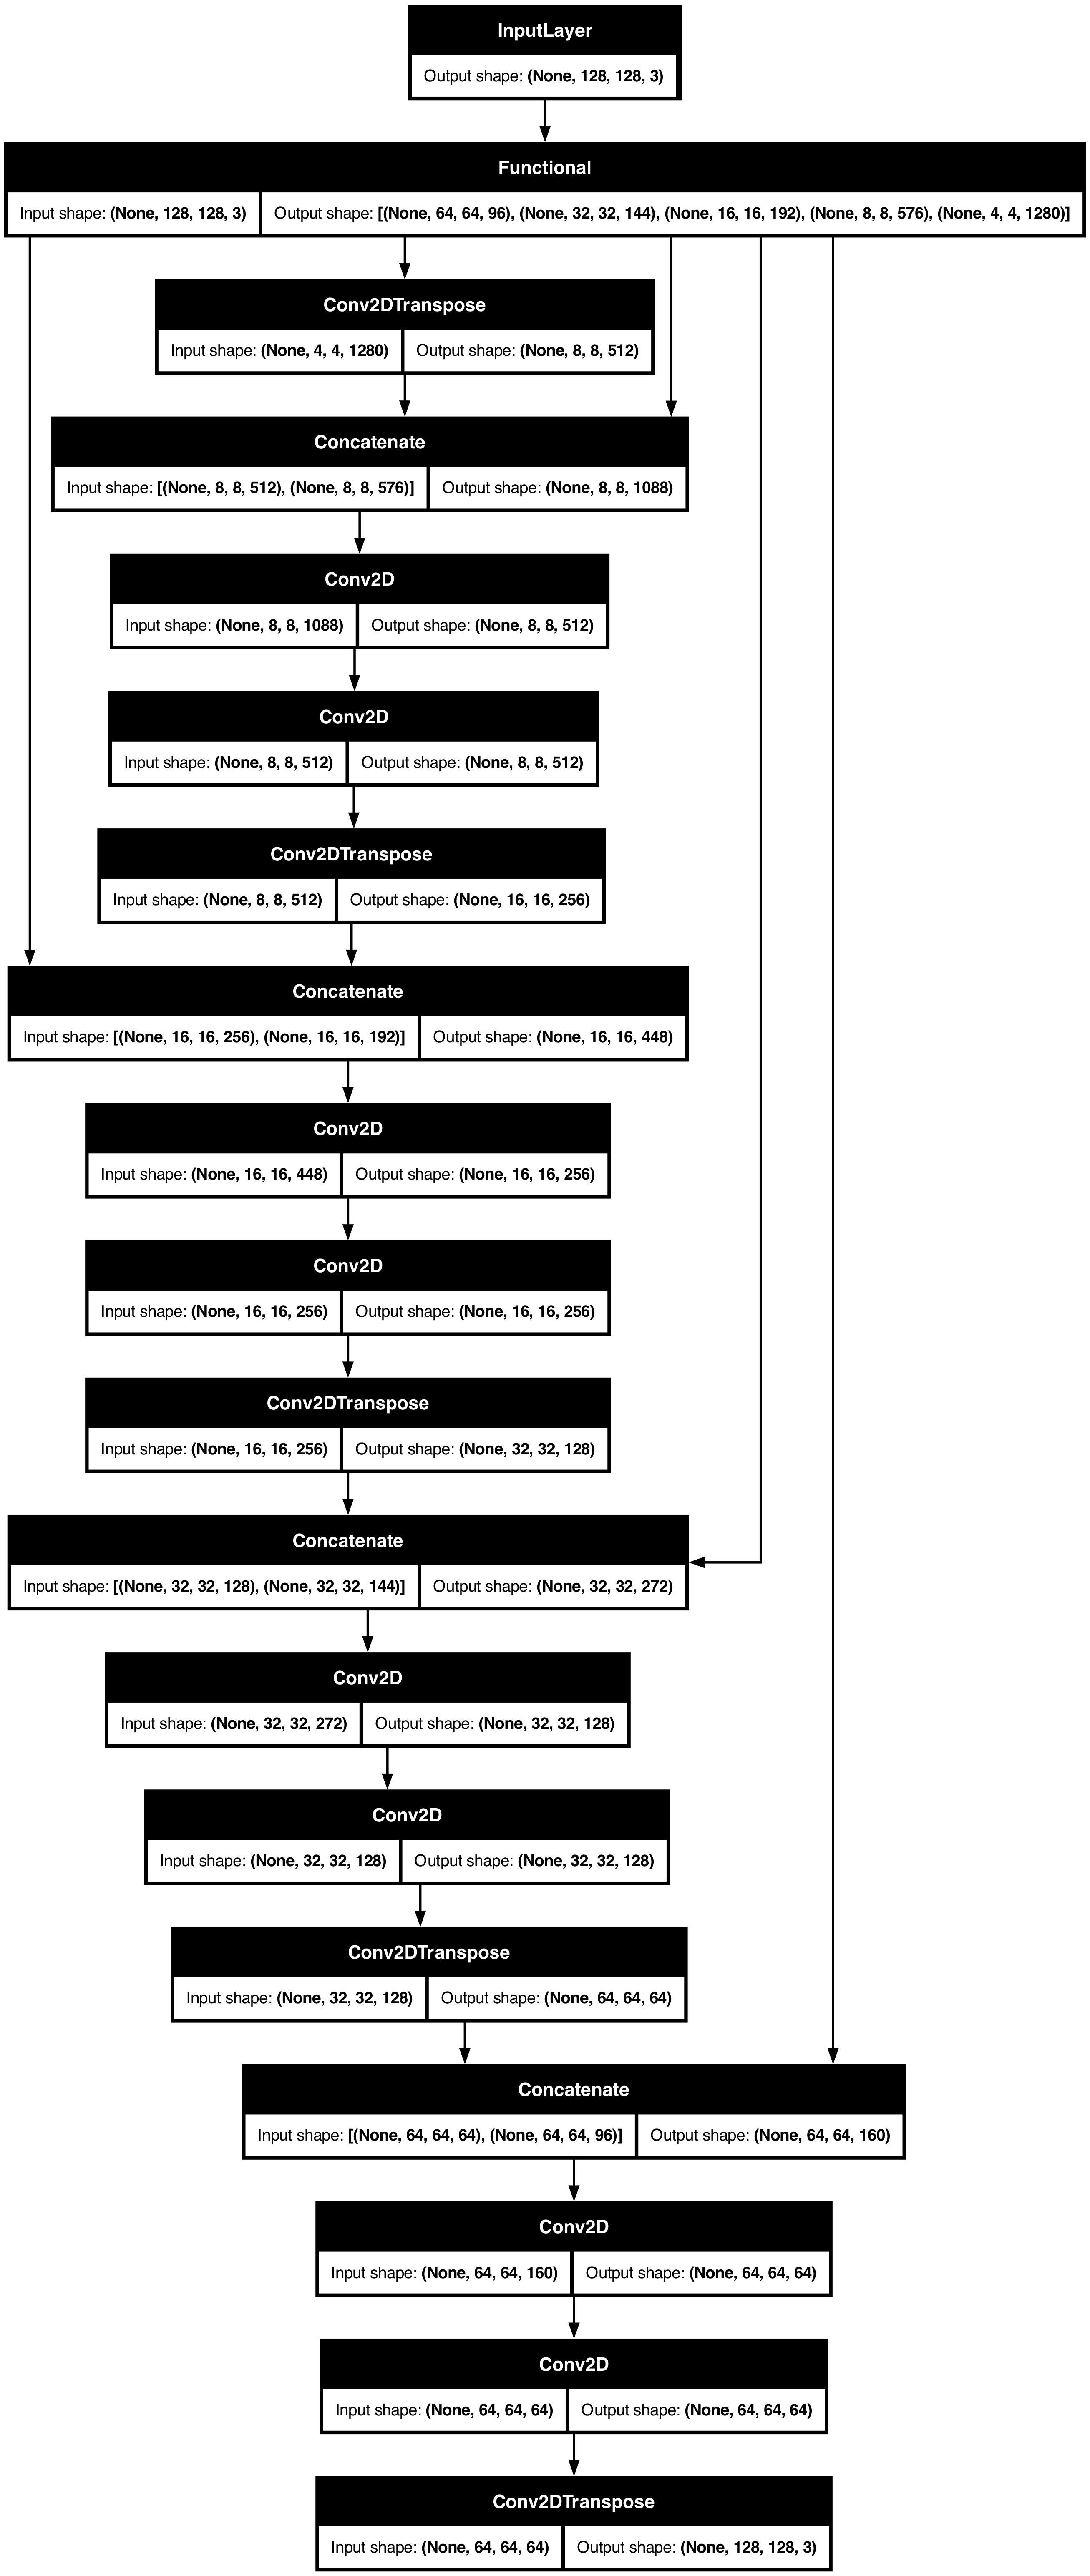

In [67]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file="model.png", show_shapes=True)

In [73]:
loaded_model

<Functional name=U-Net-MobileNet, built=True>

In [75]:
!which python
!python --version

/Users/khinchaw/.local/share/virtualenvs/KhinChaw-88KTmf34/bin/python
Python 3.11.9


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


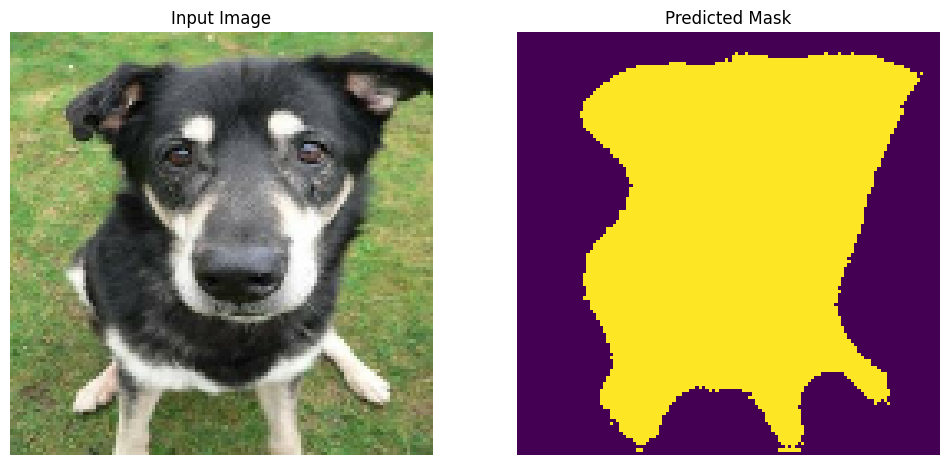

In [81]:
from tensorflow.keras.models import load_model

model_path = "models/cat_and_dog_unet.keras"  # or .keras if that's your saved format
loaded_model = load_model(model_path)

test_path = "../dataset/cat_and_dog_dataset/JPEGImages/dog.422.jpg"
predict_and_visualize(test_path, loaded_model)

In [82]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

def predict_and_show_all_masks(image_path, model, class_encodings):
    """
    Loads an image, gets a prediction, and displays the probability
    mask for every individual class.
    """
    predicted_masks,img = model_predict(image_path, model)

    
    # --- 3. Visualize the Input and All Masks ---
    num_classes = model.output_shape[-1]
    
    # Create a figure to display the results
    # We need 1 spot for the input image + num_classes spots for the masks
    plt.figure(figsize=(15, 4 * (num_classes // 3 + 1)))
    
    # Plot the input image
    plt.subplot(2, 3, 1)
    plt.title("Input Image")
    plt.imshow(tf.keras.utils.array_to_img(img))
    plt.axis('off')
    
    # Loop through each class and plot its probability mask
    for i in range(num_classes):
        # Extract the mask for the i-th class
        class_mask = predicted_masks[0, :, :, i]
        
        # Get the class name from our encodings dictionary
        # JSON keys are strings, so we convert the index `i` to a string
        class_name = class_encodings.get(str(i), f"Class {i}")
        
        plt.subplot(2, 3, i + 2)
        plt.title(f"Mask: {class_name}")
        # Display the mask as a heatmap. 'viridis' is a good colormap for this.
        plt.imshow(class_mask, cmap='viridis') 
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


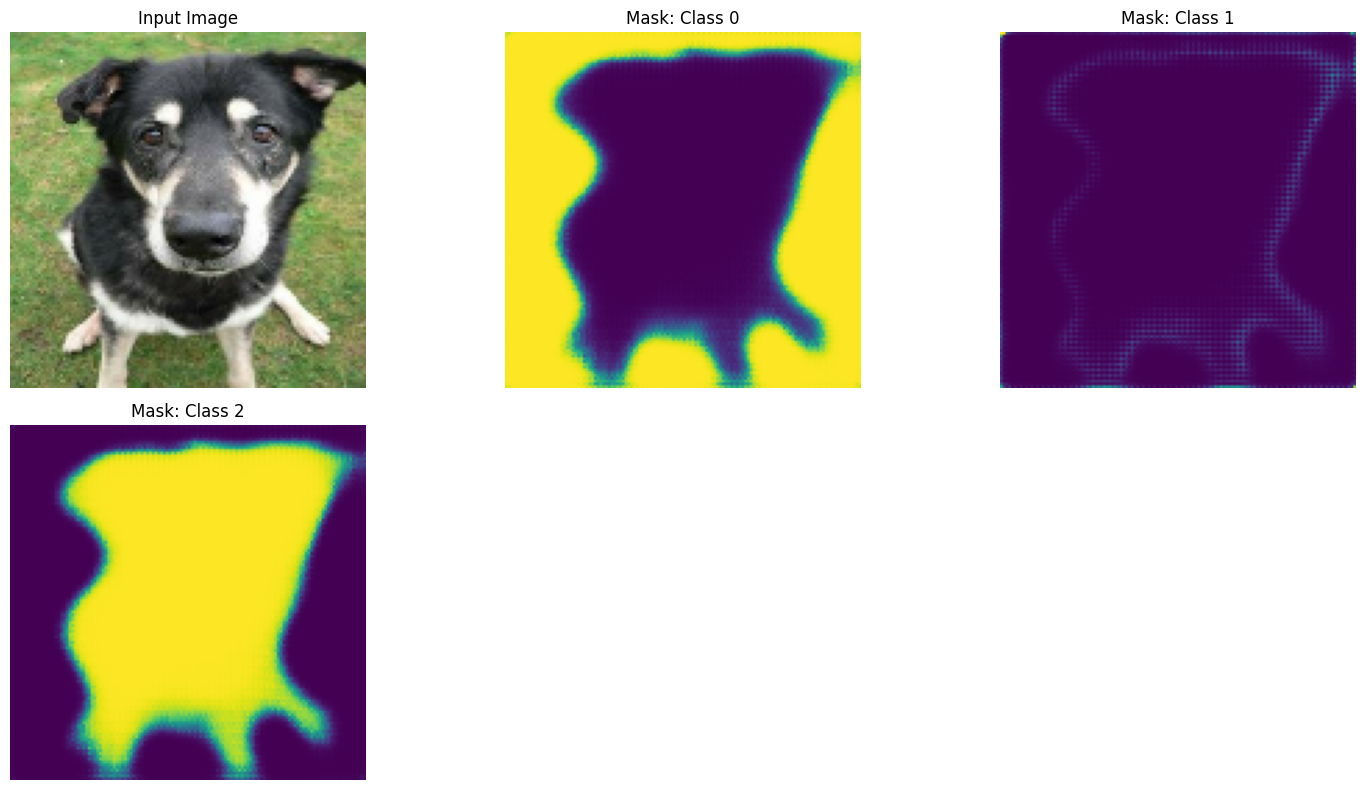

In [83]:
generic_encodings = {str(i): f"Class {i}" for i in range(NUM_CLASSES)}

predict_and_show_all_masks(test_path, loaded_model, generic_encodings)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


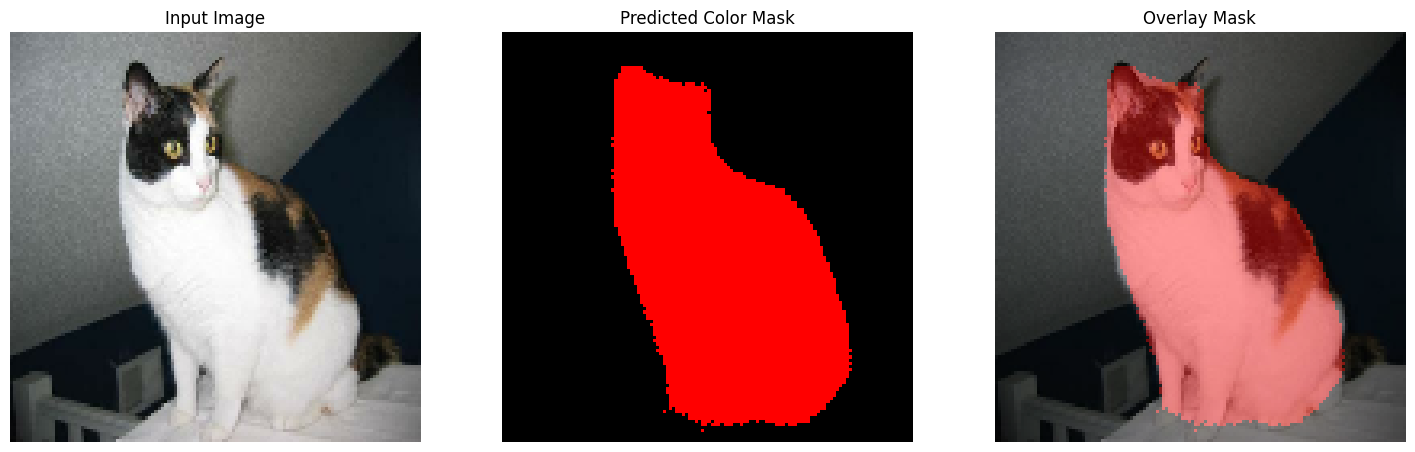

In [86]:
import numpy as np
import cv2 

# 1. Define a color for each of your 3 classes (0 to 2)
COLOR_MAP = np.array([
    [0, 0, 0],       # Class 0: Black (e.g., background)
    [255, 0, 0],     # Class 1: Red
    [0, 255, 0],     # Class 2: Green
], dtype=np.uint8)

def mask_to_rgb(mask, color_map):
    rgb_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)
    for class_idx, color in enumerate(color_map):
        rgb_mask[mask == class_idx] = color
    return rgb_mask


def predict_and_visualize_color(image_path, model, color_map):
    predicted_masks, img = model_predict(image_path, model)
    pred_mask = tf.argmax(predicted_masks, axis=-1)[0].numpy()
    
    # Convert mask to color
    color_mask = mask_to_rgb(pred_mask, color_map)
    
    # Convert original image tensor for display
    input_image_numpy = tf.keras.utils.img_to_array(img, dtype=np.uint8)
    
    # Blend the input image and the color mask for an overlay effect
    overlay = cv2.addWeighted(input_image_numpy, 0.6, color_mask, 0.4, 0)
    
    # Display the results
    plt.figure(figsize=(18, 6))
    
    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(input_image_numpy)
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.title("Predicted Color Mask")
    plt.imshow(color_mask)
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.title("Overlay Mask")
    plt.imshow(overlay)
    plt.axis('off')
    
    plt.show()


test_path = "../dataset/cat_and_dog_dataset/JPEGImages/cat.612.jpg"
predict_and_visualize_color(test_path, loaded_model, COLOR_MAP)